# **IMPORTADO DE MÓDULOS/FUNCIONES**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d


import tensorflow as tf
tf.version.VERSION
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from keras.regularizers import l2

2024-07-21 15:25:34.622827: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-21 15:25:34.649115: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-21 15:25:35.015452: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from functions import momentos, gauss, gauss_fit, get_mean_pulse_from_set, delay_pulse_pair, move_to_reference, create_and_delay_pulse_pair, create_position, calculate_gaussian_center_sigma, normalize
from Models import model_definition

# **LOAD PULSES**

In [3]:
pulsos_Na22_filt_norm = np.load('/home/josea/pulsos_Na22_filt_norm_practica_polyfit.npz')
data = pulsos_Na22_filt_norm['data']

## **INTERPOLATE**

In [4]:
#--------------------------------Interpolar pulsos reales---------------------------------
EXTRASAMPLING = 8
Nt = np.shape(data)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)

interp_func = interp1d(tiempo, data,  kind = 'cubic', axis = 1)
new_pulses = interp_func(tiempo_new)


print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

#-------------------------------------------- Align the pulses -----------------------------------
align_steps = 20
new_pulses[:,:,1] = np.roll(new_pulses[:,:,1], align_steps)
new_pulses[:,:align_steps,1] = np.random.normal(scale = 1e-3, size = align_steps)


Number of time points: 600
Time step: 0.20
New number of time points: 4800
New time step: 0.0250


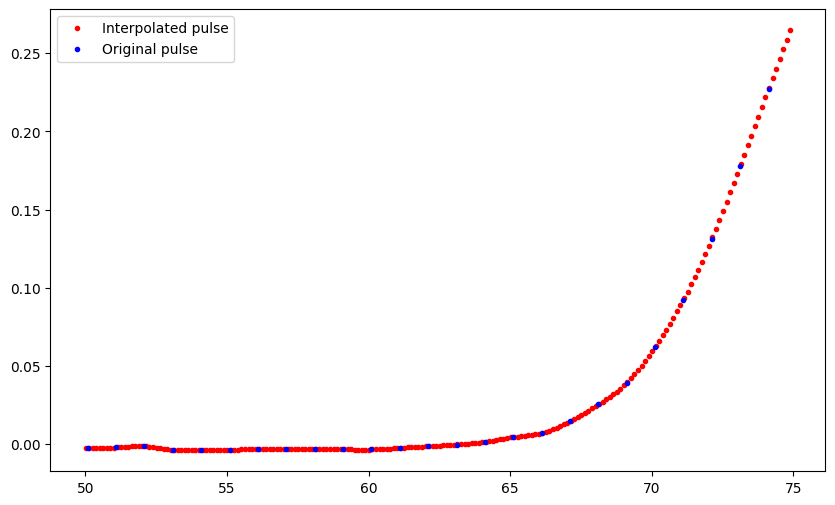

In [5]:
start = 50*EXTRASAMPLING
stop = 75*EXTRASAMPLING

plt.figure(figsize = (10,6))

t_new = np.linspace(0,Nt,Nt_new)
t = np.linspace(0,Nt,Nt)
plt.plot(t_new[start:stop],new_pulses[0,start:stop,0],'r.')
plt.plot(t[50:75], data[0,50:75,0],'b.')
plt.legend(('Interpolated pulse','Original pulse'))

# **DETECTORS**

In [6]:
Ajuste_grueso = 0  # 0 = YES, 1 = NO
delay_steps = 30  # Max number of steps to delay pulses
moments_order = 5  # Max order of moments used
nbins = 51 #Num bins for all histograms
create_positions = 1 # Wether to create new_source positions. (0 = YES, 1 = NO)                           
t_shift = 8 #Time steps to move for the new positions
epochs = 50 

#------------------------------------- Define size of train set ---------------------------------
Ntrain = int(0.8*new_pulses.shape[0])

In [7]:
if Ajuste_grueso == 0:
    
    # Calculate mean pulse in detector 
    mean_dec0 = get_mean_pulse_from_set(new_pulses, channel = 0)
    mean_dec1 = get_mean_pulse_from_set(new_pulses, channel = 1)

    # Move rest of the pulses to align with mean 
    delays_dec0, moved_pulses_dec0 = move_to_reference(mean_dec0, new_pulses[:Ntrain,:,:], start = start, stop = stop, max_delay = int(stop-start), channel = 0)
    delays_dec1, moved_pulses_dec1 = move_to_reference(mean_dec1, new_pulses[:Ntrain,:,:], start = start, stop = stop, max_delay = int(stop-start), channel = 1)

    # Create train set 
    trainX_dec0, REF_train_dec0 = create_and_delay_pulse_pair(moved_pulses_dec0, new_time_step, delay_steps = delay_steps, NOISE = True)
    trainX_dec1, REF_train_dec1 = create_and_delay_pulse_pair(moved_pulses_dec1, new_time_step, delay_steps = delay_steps, NOISE = True)

if Ajuste_grueso == 1:
    
    # Create train set
    trainX_dec0, REF_train_dec0 = create_and_delay_pulse_pair(new_pulses[:Ntrain,start:stop,0], new_time_step, delay_steps = delay_steps, NOISE = True)
    trainX_dec1, REF_train_dec1 = create_and_delay_pulse_pair(new_pulses[:Ntrain,start:stop,1], new_time_step, delay_steps = delay_steps, NOISE = True)

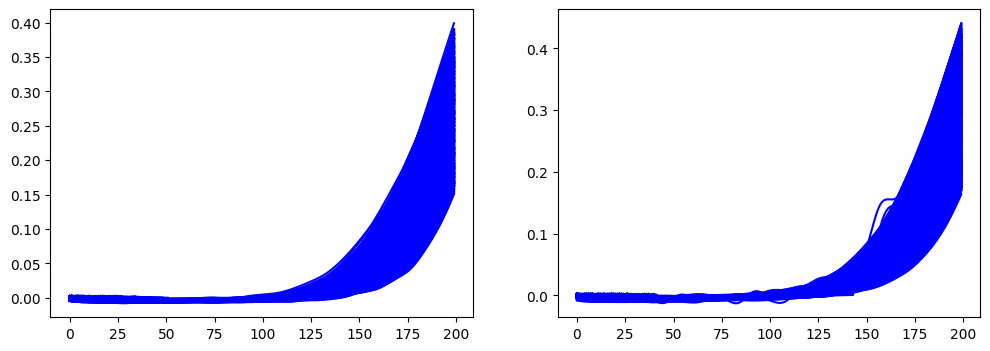

In [8]:
# Plot
plt.figure(figsize = (12,4))

plt.subplot(121)
for i in range(1000):
    plt.plot(trainX_dec0[i,:,0],'b-')
plt.subplot(122)
for i in range(1000):
    plt.plot(trainX_dec1[i,:,0],'b-')

In [9]:
#-------------------------------------------------------------- Calculate moments ------------------------------------------
M_Train_dec0 = momentos(trainX_dec0, order = moments_order)
M_Train_dec1 = momentos(trainX_dec1, order = moments_order)

#-------------------------------------------------------------- Normalize ---------------------------------------------------
M_Train_dec0, params_dec0 =  normalize(M_Train_dec0, method = 'min-max')
M_Train_dec1, params_dec1 =  normalize(M_Train_dec1, method = 'min-max')

#-------------------------------------------------------------- Print information ---------------------------------------------------
NM = np.shape(M_Train_dec0)[1]
print(M_Train_dec0.shape, "NM =", NM)
print("Normalization parameters detector 0:", params_dec0)

NM = np.shape(M_Train_dec1)[1]
print(M_Train_dec1.shape, "NM =", NM)
print("Normalization parameters detector 1:", params_dec1)

(18194, 5, 2) NM = 5
Normalization parameters detector 0: (array([-0.35898654, -0.26490973, -0.20470103, -0.16371873, -0.13470545]), array([16.39973952, 14.43843102, 12.83207102, 11.51453732, 10.42540203]))
(18194, 5, 2) NM = 5
Normalization parameters detector 1: (array([-0.30617837, -0.20368232, -0.15483781, -0.1258822 , -0.10639503]), array([12.79753222, 11.28351909, 10.09057345,  9.12012471,  8.35532908]))


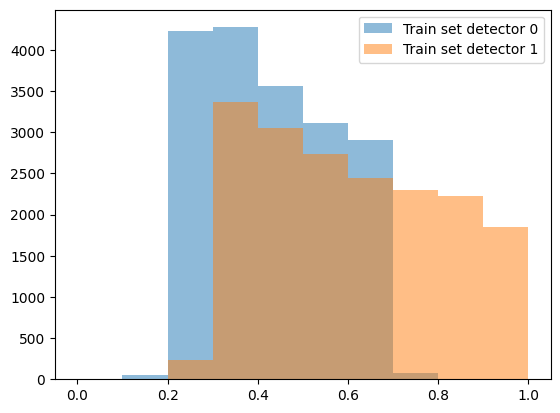

In [19]:
plt.hist(M_Train_dec0[:,1,0], alpha = 0.5, label = 'Train set detector 0');
plt.hist(M_Train_dec1[:,1,0], alpha = 0.5, label = 'Train set detector 1');
plt.legend()

# **FULL TOF**

In [11]:
REFERENCE_PULSE_dec0 = np.tile(new_pulses[0,start:stop,0], (new_pulses.shape[0],2,1)).swapaxes(1,2)
REFERENCE_PULSE_dec1 = np.tile(new_pulses[0,start:stop,1], (new_pulses.shape[0],2,1)).swapaxes(1,2)

M_REF_dec0 = momentos(REFERENCE_PULSE_dec0, moments_order)
M_REF_dec1 = momentos(REFERENCE_PULSE_dec1, moments_order)

M_REF_dec0[:,:,0] = (M_REF_dec0[:,:,0] - params_dec0[0])/(params_dec0[1] - params_dec0[0])
M_REF_dec0[:,:,1] = (M_REF_dec0[:,:,1] - params_dec0[0])/(params_dec0[1] - params_dec0[0])
M_REF_dec1[:,:,0] = (M_REF_dec1[:,:,0] - params_dec1[0])/(params_dec1[1] - params_dec1[0])
M_REF_dec1[:,:,1] = (M_REF_dec1[:,:,1] - params_dec1[0])/(params_dec1[1] - params_dec1[0])

#-------------------------------- Create test set ---------------------------------------------------------
if Ajuste_grueso == 0:
    
    delays_test_dec0, moved_pulses_test_dec0 = move_to_reference(mean_dec0, new_pulses[Ntrain:,:,:], start = start, stop = stop, max_delay = int(stop - start), channel = 0)
    delays_test_dec1, moved_pulses_test_dec1 = move_to_reference(mean_dec1, new_pulses[Ntrain:,:,:], start = start, stop = stop, max_delay = int(stop - start), channel = 1)
 
    TEST = np.stack((moved_pulses_test_dec0, moved_pulses_test_dec1), axis = 2)
    TEST_02 = create_position(TEST, channel_to_move = 1, channel_to_fix = 0, t_shift = t_shift, NOISE = True)
    TEST_20 = create_position(TEST, channel_to_move = 0, channel_to_fix = 1, t_shift = t_shift, NOISE = True)

if Ajuste_grueso == 1:
    
    TEST = new_pulses[Ntrain:,start:stop,:]
    TEST_02 = create_position(TEST, channel_to_move = 1, channel_to_fix = 0, t_shift = t_shift, NOISE = True)
    TEST_20 = create_position(TEST, channel_to_move = 0, channel_to_fix = 1, t_shift = t_shift, NOISE = True)
    print(TEST.shape)


M_Test_00 = momentos(TEST, order = moments_order)
M_Test_00[:,:,0] = (M_Test_00[:,:,0] - params_dec0[0])/(params_dec0[1] - params_dec0[0])
M_Test_00[:,:,1] = (M_Test_00[:,:,1] - params_dec1[0])/(params_dec1[1] - params_dec1[0])

M_Test_02 = momentos(TEST_02, order = moments_order)
M_Test_02[:,:,0] = (M_Test_02[:,:,0] - params_dec0[0])/(params_dec0[1] - params_dec0[0])
M_Test_02[:,:,1] = (M_Test_02[:,:,1] - params_dec1[0])/(params_dec1[1] - params_dec1[0])

M_Test_20 = momentos(TEST_20, order = moments_order)
M_Test_20[:,:,0] = (M_Test_20[:,:,0] - params_dec0[0])/(params_dec0[1] - params_dec0[0])
M_Test_20[:,:,1] = (M_Test_20[:,:,1] - params_dec1[0])/(params_dec1[1] - params_dec1[0])


In [15]:
model_dec0 = model_definition(NM = NM, NN = 128, STD_INIT = 0.5)
model_dec1 = model_definition(NM = NM, NN = 128, STD_INIT = 0.5)
  
opt_dec0 = tf.keras.optimizers.AdamW(learning_rate = 7e-5)
opt_dec1 = tf.keras.optimizers.AdamW(learning_rate = 7e-5)

model_dec0.compile(optimizer = opt_dec0,loss = 'MSE')
model_dec1.compile(optimizer = opt_dec1,loss = 'MSE')


loss_dec0 = []
loss_dec1 = []
TOFN_02_epoch = []
TOFN_00_epoch = []
TOFN_20_epoch = []


for epoch in range(epochs):
     
  history_dec0 = model_dec0.fit(x = [M_Train_dec0[:,:,0], M_Train_dec0[:,:,1]], y = REF_train_dec0, epochs = 15, batch_size = 512, verbose = 1)
  history_dec1 = model_dec1.fit(x = [M_Train_dec1[:,:,0], M_Train_dec1[:,:,1]], y = REF_train_dec1, epochs = 15, batch_size = 512, verbose = 1)

  loss_dec0.append(history_dec0.history['loss'][-1])
  loss_dec1.append(history_dec1.history['loss'][-1])

  TOFN_dec0_REF_02 = model_dec0.predict([M_Test_02[:,:,0], M_REF_dec0[:M_Test_02.shape[0],:,0]])
  TOFN_dec1_REF_02 = model_dec1.predict([M_Test_02[:,:,1], M_REF_dec1[:M_Test_02.shape[0],:,0]])
  TOFN_dec0_REF_00 = model_dec0.predict([M_Test_00[:,:,0], M_REF_dec0[:M_Test_00.shape[0],:,0]])
  TOFN_dec1_REF_00 = model_dec1.predict([M_Test_00[:,:,1], M_REF_dec1[:M_Test_00.shape[0],:,0]])
  TOFN_dec0_REF_20 = model_dec0.predict([M_Test_20[:,:,0], M_REF_dec0[:M_Test_20.shape[0],:,0]])
  TOFN_dec1_REF_20 = model_dec1.predict([M_Test_20[:,:,1], M_REF_dec1[:M_Test_20.shape[0],:,0]])
          
  if Ajuste_grueso == 0:   
    
    TOFN_02 = (np.squeeze(TOFN_dec0_REF_02) - new_time_step*delays_test_dec0) - (np.squeeze(TOFN_dec1_REF_02) - new_time_step*delays_test_dec1)
    TOFN_00 = (np.squeeze(TOFN_dec0_REF_00) - new_time_step*delays_test_dec0) - (np.squeeze(TOFN_dec1_REF_00) - new_time_step*delays_test_dec1)
    TOFN_20 = (np.squeeze(TOFN_dec0_REF_20) - new_time_step*delays_test_dec0) - (np.squeeze(TOFN_dec1_REF_20) - new_time_step*delays_test_dec1)

  if Ajuste_grueso == 1:  
    
    TOFN_02 = np.squeeze(TOFN_dec0_REF_02) - np.squeeze(TOFN_dec1_REF_02)
    TOFN_00 = np.squeeze(TOFN_dec0_REF_00) - np.squeeze(TOFN_dec1_REF_00)
    TOFN_20 = np.squeeze(TOFN_dec0_REF_20) - np.squeeze(TOFN_dec1_REF_20)
        
  TOFN_02_epoch.append(TOFN_02)
  TOFN_00_epoch.append(TOFN_00)
  TOFN_20_epoch.append(TOFN_20)
  
  tf.keras.backend.clear_session()


training_loss_dec0 = np.array(loss_dec0, dtype = 'object')
training_loss_dec1 = np.array(loss_dec1, dtype = 'object')


TOFN_02_array = np.array(TOFN_02_epoch, dtype = 'object')
TOFN_00_array = np.array(TOFN_00_epoch, dtype = 'object')
TOFN_20_array = np.array(TOFN_20_epoch, dtype = 'object')

# Calculate 'centroids'
centroid_V00, sigmaN_V00 = calculate_gaussian_center_sigma(TOFN_00_array, np.zeros((TOFN_00_array.shape[0])), nbins = nbins)
centroid_V02, sigmaN_V02 = calculate_gaussian_center_sigma(TOFN_02_array, centroid_V00, nbins = nbins)  
centroid_V20, sigmaN_V20 = calculate_gaussian_center_sigma(TOFN_20_array, centroid_V00, nbins = nbins)

Epoch 1/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 83.7587 
Epoch 2/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 82.3450
Epoch 3/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - loss: 81.7893
Epoch 4/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 81.2439
Epoch 5/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 80.6974
Epoch 6/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - loss: 80.1504
Epoch 7/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 79.6038
Epoch 8/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 79.0580 
Epoch 9/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - loss: 78.5135
Epoch 10/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 77.9704
Epoch 11/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - loss: 77.4292
Epoch 12/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - loss: 76.8900
Epoch 13/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - loss: 76.3527
Epoch 14/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 75.8177
Epoch 15/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 807us

12 0.10787208225497161
V02 MAE: 0.10896828142054342
V00 MAE: 0.1080004370951798
V20 MAE: 0.10664752824919033


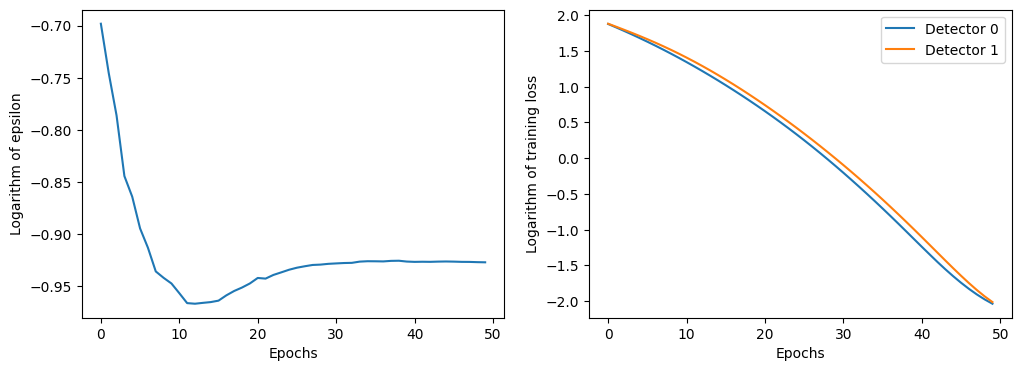

In [16]:
training_loss_dec0 = np.array(training_loss_dec0, dtype = 'float64')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'float64')

# Get errors to calculate Epsilon
error_V02 = abs((TOFN_02_array - centroid_V00[:, np.newaxis] + 0.2))
error_V00 = abs((TOFN_00_array - centroid_V00[:, np.newaxis]))
error_V20 = abs((TOFN_20_array - centroid_V00[:, np.newaxis] - 0.2))

Error = np.concatenate((error_V00, error_V20, error_V02), axis = 1)
MAE = np.mean(Error, axis = 1)
MAE = np.array(MAE, dtype = 'float64')
idx_min_MAE = np.where(MAE == np.min(MAE))[0][0]
print(idx_min_MAE, np.min(MAE))
print('V02 MAE:', np.mean(error_V02[idx_min_MAE,:]))
print('V00 MAE:', np.mean(error_V00[idx_min_MAE,:]))
print('V20 MAE:', np.mean(error_V20[idx_min_MAE,:]))



plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
plt.plot(np.log10(MAE))
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')


plt.subplot(1,2,2)
plt.plot(np.log10(training_loss_dec0), label = 'Detector 0')
plt.plot(np.log10(training_loss_dec1), label = 'Detector 1')
plt.ylabel('Logarithm of training loss')
plt.xlabel('Epochs')
plt.legend()



02: CENTROID(ns) = -0.213  FWHM(ns) = 0.264  std(ns) = 0.112
00: CENTROID(ns) = -0.008  FWHM(ns) = 0.261  std(ns) = 0.111
20: CENTROID(ns) = 0.192  FWHM(ns) = 0.258  std(ns) = 0.109


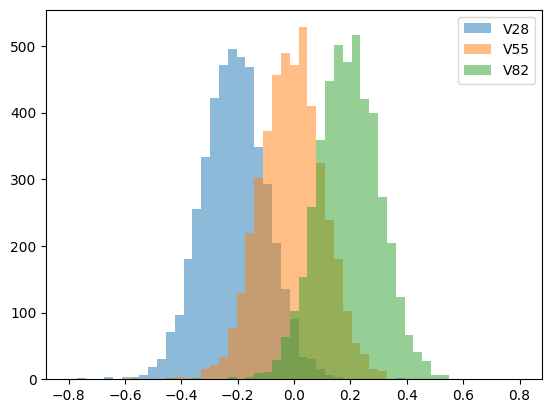

In [17]:
epoch = idx_min_MAE
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
histogN_02, binsN, patchesN  = plt.hist(TOFN_02_array[epoch,:] - np.mean(TOFN_00_array[epoch,:]), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_02, sigmaN_02 = gauss_fit(cbinsN, histogN_02)

histogN, binsN, patchesN  = plt.hist(TOFN_00_array[epoch,:] - np.mean(TOFN_00_array[epoch,:]), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_00, sigmaN_00 = gauss_fit(cbinsN, histogN)

histogN_20, binsN, patchesN  = plt.hist(TOFN_20_array[epoch,:] - np.mean(TOFN_00_array[epoch,:]), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_20, sigmaN_20 = gauss_fit(cbinsN, histogN_20)
plt.legend()


FWHMN_02 = 2.35482 * sigmaN_02
FWHMN_00 = 2.35482 * sigmaN_00
FWHMN_20 = 2.35482 * sigmaN_20


print('')
print("02: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_02, FWHMN_02, sigmaN_02))
print("00: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_00, FWHMN_00, sigmaN_00))
print("20: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_20, FWHMN_20, sigmaN_20))